<a href="https://colab.research.google.com/github/compartia/nlp_tools/blob/tensorflow-model/augmentation_NER_Matcher_(TF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
GLOBALS__={}

## MAIN, init, load code

In [0]:
#@title  { form-width: "300px", display-mode: "form" }
import os






# ''' AZ:-IMPORT CODE GITHUB----------------------------------------------😺------ '''
import sys
# ====================================
# ====================================
_git_branch = "tensorflow-model"  # @param {type:"string"}
# ====================================
# ====================================


def _init_import_code_from_gh():
  if 'GLOBALS__' not in globals():
    print('adding global GLOBALS__')
    global GLOBALS__
    GLOBALS__ = {}

  if '_init_import_code_from_gh' in GLOBALS__:
    print('👌 code already imported from GitHub!')
    return

  import subprocess
  def exec(x):
    r = subprocess.check_output(x, shell=True)
    r = r.decode('unicode-escape').encode('latin1').decode('utf8')
    print(r)

  print(f"fetching code from GitHub.....{_git_branch}")
  try:
    exec('rm -r nlp_tools')
  except:
    pass
  exec(f'git clone --single-branch --branch {_git_branch} https://github.com/compartia/nlp_tools.git nlp_tools')

  print('🦊 GIT revision:')
  exec('cd nlp_tools\ngit rev-list --reverse HEAD | awk "{ print NR }" | tail -n 1\ngit branch\ngit log -3 --pretty=%B')

  sys.path.insert(0, 'nlp_tools')

  # self-test
  from text_tools import untokenize
  print(untokenize(['code', 'imported', 'OK 👍']))

  print('installing antiword...')
  exec('sudo apt-get install antiword')

  print('installing docx2txt...')
  exec("pip install docx2txt")

  GLOBALS__['_init_import_code_from_gh'] = True

  ''' AZ:-------------------------------------------------IMPORT CODE GITHUB-😺---'''
  print('❤️ DONE importing Code fro GitHub')


# AZ:-INIT ELMO-----------------------------------------------------------------------------------

import tensorflow_hub as hub

#
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML


 

# AZ:- THE CODE----------------------------------------------------------------------------------

def _init_the_code(reset=False):
  if '_init_the_code' in GLOBALS__ and not reset:
    print('👌 Code is alredy imported!')
    return

  from renderer import HtmlRenderer
  from renderer import to_multicolor_text
  from renderer import known_subjects_dict

  from structures import ContractSubject
  from contract_parser import ContractDocument3

  from ml_tools import ProbableValue

  from legal_docs import LegalDocument
  from renderer import as_warning, as_headline_3, as_offset, as_smaller

  class DemoRenderer(HtmlRenderer):

    def render_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None):
      html = self.to_color_text(tokens, weights, colormap, print_debug, _range)
      display(HTML(html))

    def to_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None):
      return super()._to_color_text(tokens, weights, mpl, colormap=colormap, _range=_range)

    def render_multicolor_text(self, tokens, vectors, colormap, min_color=None, _slice=None):
      display(HTML(to_multicolor_text(tokens, vectors, colormap, min_color=min_color, _slice=_slice)))

     
     

     
  GLOBALS__['renderer'] = DemoRenderer()

  GLOBALS__['_init_the_code'] = True
  print("❤️ DONE initializing the code")

  # AZ:-------------------------------------------------Init Protocols context===


def read_doc(fn):
  import docx2txt, sys, os

  text = ''
  try:
    text = docx2txt.process(fn)

  except:
    print("Unexpected error:", sys.exc_info())
    os.system('antiword -w 0 "' + fn + '" > "' + fn + '.txt"')
    with open(fn + '.txt') as f:
      text = f.read()

  return text

def interactive_upload(filetype):
  from google.colab import files
  import docx2txt

  print(f'Please select "{filetype}" .docx file:')
  uploaded = files.upload()
  docs = []
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

    with open(fn, "wb") as df:
      df.write(uploaded[fn])
      df.close()

    # extract text

    text = ''
    try:
      text = docx2txt.process(fn)
    except:
      print("Unexpected error:", sys.exc_info())
      os.system('antiword -w 0 "' + fn + '" > "' + fn + '.txt"')
      with open(fn + '.txt') as f:
        text = f.read()
    print("Символов в оригинальном документе:", len(text))
    docs.append(text)
    return docs

  
# AZ:- ENDO OF THE THE CODE------------------------------------------------XXXX


# 1.
_init_import_code_from_gh()
 
# 3.
_init_the_code(True)



### load files from gdrive

In [0]:

from google.colab import auth
from google.colab import drive
 

drive.mount('/content/gdrive', force_remount=True)


import glob
def read_documents(filename_prefix):
  texts = {}
  for file in glob.glob(filename_prefix+"*.doc"):
    try:
      text = read_doc(file)
      texts[file] = text
      print("good:", file)
    except:
      print('WRONG *.doc FILE!!', file)

  for file in glob.glob(filename_prefix+"*.docx"):
    try:
      text = read_doc(file)
      texts[file] = text
      print("good:", file)
    except:
      print('WRONG *.docx FILE!!', file)
      
  return texts

contracts_filename_prefix='/content/gdrive/My Drive/GazpromOil/Contracts/'
contracts = read_documents(contracts_filename_prefix)


assert len(contracts) > 0


#Разметка договоров ( regEx)
 - чтение докуметов
 - поиск по шаблонам (org name, org type, org alias, etc)
 - формирование one-hot векторов (матрицы), она будет использована в TF(keras?) модели как labels

### Rendering utils

In [0]:
def color_matrix(matrix, tokens):
    
  mt = matrix.T

  colormap = {
      
    '0': (1, 0, 0),
    '1': (0, 0.3, 1),
        
    '0.type': (0, 1, 0.6),
    '1.type': (0, 1, 0.5),
      
    '0.name': (1, 0.7, 0),
    '1.name': (1, 0.5, 0),

    '0.alias': (0.3, 1, 0),
    '1.alias': (0.2, 1, 0),

    '0.alt_name': (0.6, 0.2, 0),
    '1.alt_name': (0.6, 0.2, 0),
  }
  
  
  vectors = {}
  for k in range( int(matrix.shape[1] )):
    key = f'{int(k/len(entities_types))}.{entities_types[k%len(entities_types)]}'
    vectors[key] = mt[k]
  
 

  GLOBALS__['renderer'].render_multicolor_text(tokens, vectors, colormap, min_color=(0.4, 0.4, 0.4) )
  
  
##------------
def plot_matrix(matrix):
    
  mt = matrix.T
  
  with sns.axes_style("white"):
    plt.figure(figsize=(25, 3))
    ax = sns.heatmap(mt, square=False,  cmap="YlGnBu")
    plt.show()


## Разметка

#### Идея! 💡 
Склеить матрицу категорий `M` (в которой большенство -- нули (sparce) ) с инвертированной матрицей  `1-M`

Таким образом, ни один класс не будет доминировать

- Update: пока провал 💀


In [0]:
def double_label_matrix_by_inversion(matrix):
  rows = matrix.shape[0]
  cols = matrix.shape[1]
  
  matrix_double = np.zeros((rows*2, cols))
  matrix_double[0:rows,0:cols] = matrix
  matrix_double[rows:2*rows,0:cols] = 1-matrix
  return matrix_double
    

In [0]:
import numpy as np

from contract_agents import find_org_names, normalize_contract
from text_tools import tokenize_text, tokens_in_range

# TODO: import this
entities_types = ['type', 'name', 'alt_name', 'alias', 'type_ext']


def preprocess_contract(txt):
  trimmed = txt[0:3000]
  normalized_contract = normalize_contract(trimmed)
  return normalized_contract


def validate_find_patterns_in_contract_results(d):
  assert len(d) == 2


#   TODO:

def find_patterns_in_contract(normalized_contract: str):
  tokens = tokenize_text(normalized_contract)

  agents_infos = find_org_names(normalized_contract)
  validate_find_patterns_in_contract_results(agents_infos)

  cols = len(tokens)
  return make_matrix( (normalized_contract, agents_infos), cols )
 


def make_matrix(contract_info:tuple, matrix_len):
  tokens = tokenize_text(contract_info[0])
  agents_infos = contract_info[1]
   
  rows_per_org = len(entities_types)
  rows = 2 * rows_per_org   

  matrix = np.zeros((rows, matrix_len))

  for agent_n in range(2):
    org = agents_infos[agent_n]

    for i in range(rows_per_org):
      entity_type = entities_types[i]
      row =  agent_n * rows_per_org + i

      span = org[entity_type][1]

      if span[0] > 0:
        text_slice = tokens_in_range(span, tokens, contract_info[0])
        matrix[row][text_slice] = 1.0

      row += 1
  
  #   print(agents_infos[0])
  #   print(agents_infos[1])
  
 
  return matrix.T

  
 
  
  
### TESTS 🔞============✂️============⚙️========================================

import matplotlib.pyplot as plt
import seaborn as sns



  
t = preprocess_contract( list(contracts.values())[1] )
tokens = tokenize_text(t)
matrix = find_patterns_in_contract(t)


print(matrix[0])

color_matrix(matrix, tokens)
plot_matrix(matrix)

# Keras models

In [7]:
 

import os
import numpy as np

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

from keras.activations import relu
from keras.models import Sequential, Model
from keras.layers import Concatenate, Input, Flatten, Conv1D, MaxPooling1D, Lambda, Add, BatchNormalization
from keras.layers import Dropout, concatenate
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report

from IPython.display import SVG

Using TensorFlow backend.


## Make dataset

### Augmentaion metoden

In [0]:
import random
import re
from typing import AnyStr, Match, Dict, List

def make_rnanom_name(lenn) -> str:
  return ''.join(random.choices('АБВГДЕЖЗИКЛМН', k=1) + random.choices('абвгдежопа ', k=lenn))


def augment_contract(txt: str, org_infos: List[Dict]):
  txt_a = txt
  for org in org_infos:
    for e in ['name', 'alias', 'alt_name']:
      substr = org[e][0]
      if substr and substr!='':
        r = re.compile(substr)
        txt_a = re.sub(r, make_rnanom_name(10), txt_a)

  return txt_a, find_org_names(txt_a)

In [0]:
data = list(contracts.keys())

PARSED=[]
for fn in data:  
  con = contracts[fn]
  normalized_contract = preprocess_contract( con )
  
  try:
    agents_infos = find_org_names(normalized_contract)
    validate_find_patterns_in_contract_results(agents_infos)
#     PARSED.append( (normalized_contract, agents_infos) )


    for c in range(5):
      PARSED.append( augment_contract (normalized_contract, agents_infos) )
     
  except:
    print(f'ERROR: {fn}')

for e in PARSED:
  print(e[1])
  
  
##-----------------
from text_tools import untokenize

_TEXTS=[]
_TEXTS_tmp=[]
_LENS_tmp=[]

_LABELS=[]
_LENS=[]
data = list(contracts.keys())

 
for t, _ in PARSED:  
  tokens = tokenize_text(t)  
  _TEXTS_tmp.append(tokens)
  _LENS_tmp.append(len(tokens))

#PADDING
 
_longest_len = _LENS_tmp[np.argmax(_LENS_tmp)  ]  +10
print('_longest_len',_longest_len)
for i in range(len(_TEXTS_tmp)):
  _TEXTS_tmp[i] = _TEXTS_tmp[i] + ['PAD']* (_longest_len - len(_TEXTS_tmp[i]))
  

for i in range( len(PARSED)):  #:[39:45]:

  tokens = _TEXTS_tmp[i]
  t = PARSED[i][0]


  ###-----
  matrix = make_matrix(PARSED[i], _longest_len)
  ###----
 
  assert len(matrix) == _longest_len

  _TEXTS.append(tokens)
  _LENS.append(len(tokens))
  _LABELS.append(matrix)



  
  
np_LABELS = np.array(_LABELS)

print(len(_TEXTS))

In [10]:
TEST_TOKENS = tokenize_text( preprocess_contract(contracts['/content/gdrive/My Drive/GazpromOil/Contracts/Договор_ООО Зодчий_25 млн.$.docx']))
print(_longest_len)

550


### Plot sample label  matrices

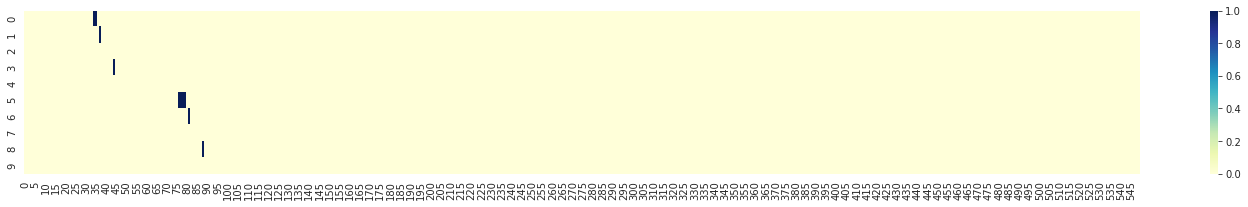

In [11]:
for m in _LABELS[9:10]:
  plot_matrix(m) 

# MODELS

In [0]:
EPOCHS = 40

####  support  methods

In [0]:

import tensorflow as tf

module_url = 'https://storage.googleapis.com/az-nlp/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz'


In [0]:
EMB_DIM = 1024

def get_embedings(inputs):
  r = elmo(
    inputs={
      "tokens": inputs[0],
      "sequence_len": tf.squeeze(inputs[1])
    },
    signature="tokens",
    as_dict=True)["elmo"]

  return r


# ------
def elmo_output_shape(input_shapes):
  shape1 = list(input_shapes[0])
  shape1+= [EMB_DIM]
  return tuple(shape1)




In [0]:
from keras import backend as K
from keras.objectives import categorical_crossentropy
from keras.optimizers import Adam
from keras.layers import LSTM, Flatten

 
def custom_loss(y_true, y_pred):
  return K.mean( K.square(y_pred - y_true) )
  
  
def get_conv_pool(x_input, sufix, feature_maps, n=3, activation='relu'):
  branch = Conv1D( filters = feature_maps, kernel_size=(n), padding='same', activation=activation, name='Conv_'+sufix+'_'+str(n))(x_input)
  return branch



def custom_categorical_crossentropy(x, y):
    x = K.flatten(x)
    y = K.flatten(y)
    return categorical_crossentropy(x, y)
  
  
def plot_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  

## 0:  CNN-only Model

In [0]:
def build_cnn_only_model(features): 

  # inputs:--------------------------------------------------------------------
  text_input = Input(shape=[None,], dtype='string', name="text_input")
  text_lengths = Input(batch_shape=[None, 1], dtype='int32', name='text_lengths')
  # ------------------------------------------------------------------- /inputs
   
  embedding = Lambda(get_embedings, elmo_output_shape, name="deeppavlov".upper())( [text_input, text_lengths]  )

  conv_0 = get_conv_pool(embedding, 'c0', n=4, feature_maps=2, activation='sigmoid' )  
  conv_00 = get_conv_pool(embedding, 'blurry', n=10, feature_maps=2, activation='sigmoid' )  
  conv_1 = get_conv_pool(embedding, 'c1', n=3, feature_maps=features*2, activation='sigmoid' )  
  conv_2 = get_conv_pool(embedding, 'c2', n=5, feature_maps=features*2, activation='sigmoid')

  
  _out = Concatenate()([conv_00, conv_0, conv_1, conv_2]) 

  _out = get_conv_pool(_out, 'c3', n=3, feature_maps=features, activation='sigmoid')

  _out = get_conv_pool(_out, 'c4', n=3, feature_maps=features, activation='sigmoid')
  
  model = Model(inputs=[text_input, text_lengths], outputs=_out)

  adam = Adam(lr=0.05, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#   model.compile(loss=custom_categorical_crossentropy, optimizer=adam)
  model.compile(loss=custom_categorical_crossentropy, optimizer=adam, metrics=['accuracy'])

  model.summary()
  
  return model

In [17]:

graph = tf.Graph()
with graph.as_default():  
  elmo = hub.Module(module_url, trainable=False)
  model = build_cnn_only_model( np_LABELS.shape[-1] )
  
  


W0516 03:35:46.364799 140065809811328 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
text_lengths (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
DEEPPAVLOV (Lambda)             (None, None, 1024)   0           text_input[0][0]                 
                                                                 text_lengths[0][0]               
__________________________________________________________________________________________________
Conv_blurry_10 (Conv1D)         (None, None, 2)      20482       DEEPPAVLOV[0][0]                 
__________

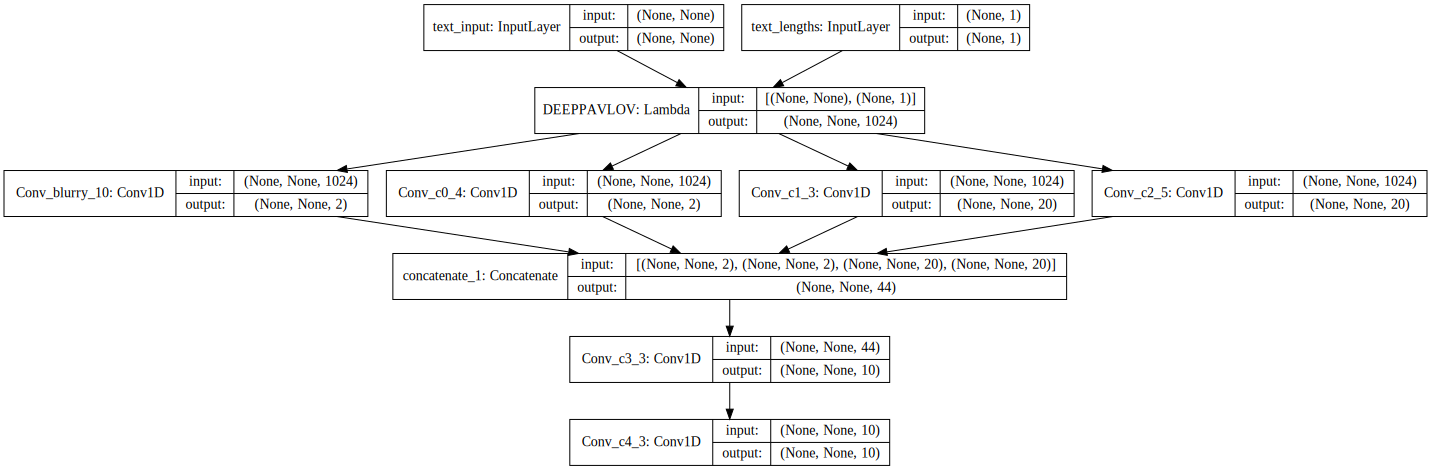

In [18]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

W0516 03:35:49.396506 140065809811328 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 112 samples, validate on 38 samples
Epoch 1/40
112/112 [==============================] - 19s 171ms/step - loss: 4808.4465 - acc: 0.0099 - val_loss: 4356.2922 - val_acc: 0.9764
Epoch 2/40
112/112 [==============================] - 13s 120ms/step - loss: 4552.2563 - acc: 0.9772 - val_loss: 3999.8519 - val_acc: 0.9330
Epoch 3/40
112/112 [==============================] - 13s 118ms/step - loss: 4133.8329 - acc: 0.9292 - val_loss: 3498.6001 - val_acc: 0.9400
Epoch 4/40
112/112 [==============================] - 13s 118ms/step - loss: 3621.1754 - acc: 0.9500 - val_loss: 3288.8870 - val_acc: 0.9513
Epoch 5/40
112/112 [==============================] - 13s 119ms/step - loss: 3403.3745 - acc: 0.9471 - val_loss: 3175.8105 - val_acc: 0.9388
Epoch 6/40
112/112 [==============================] - 14s 124ms/step - loss: 3344.9231 - acc: 0.9503 - val_loss: 3150.8824 - val_acc: 0.9512
Epoch 7/40
112/112 [==============================] - 14s 121ms/step - loss: 3313.0613 - acc: 0.9498 - val_lo

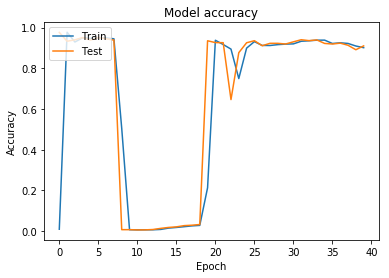

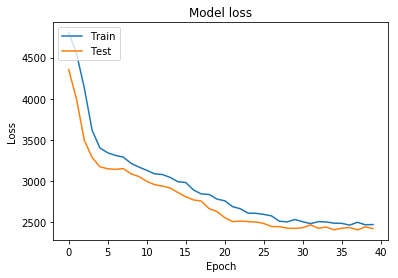

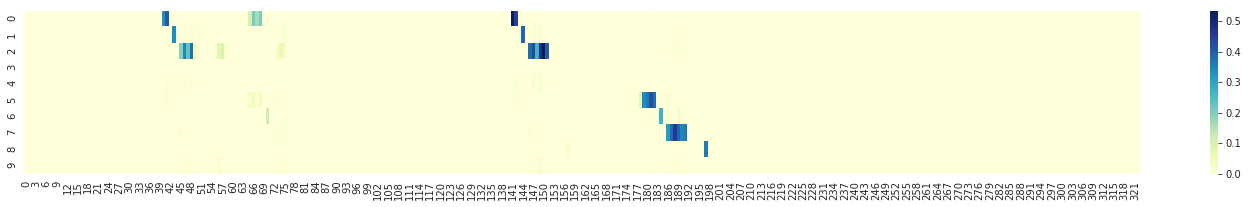

In [19]:

with graph.as_default():  
 
  with tf.Session() as sess:
   
    K.set_session(sess) 
    
    for i in range(1):
      history = model.fit([_TEXTS[5:], _LENS[5:] ], np_LABELS[5:], validation_split=0.25, epochs=EPOCHS, batch_size=30)
      plot_training_history(history)
      pred = model.predict([ [TEST_TOKENS, TEST_TOKENS], [len(TEST_TOKENS), len(TEST_TOKENS)] ])
      
      plot_matrix(pred[0])
#       color_matrix(pred[0], TEST_TOKENS)
      
      

      



## 1:  CNN + 1 LSTM Model

In [0]:
def build_big_model(features): 

  # inputs:--------------------------------------------------------------------
  text_input = Input(shape=[None,], dtype='string', name="text_input")
  text_lengths = Input(batch_shape=[None, 1], dtype='int32', name='text_lengths')
  # ------------------------------------------------------------------- /inputs
   
  embedding = Lambda(get_embedings, elmo_output_shape, name="deeppavlov".upper())( [text_input, text_lengths]  )

  conv_0 = get_conv_pool(embedding, 'c0', n=4, feature_maps=2, activation='sigmoid' )  
  conv_00 = get_conv_pool(embedding, 'blurry', n=10, feature_maps=2, activation='sigmoid' )  
  conv_1 = get_conv_pool(embedding, 'c1', n=3, feature_maps=features*2, activation='sigmoid' )  
  conv_2 = get_conv_pool(embedding, 'c2', n=5, feature_maps=features*2, activation='sigmoid')
  

  
#   conv_1 = BatchNormalization()(conv_1)
#   conv_sum = Add()([conv_1, conv_2]) 
  
  conv_sum = Concatenate()([conv_00, conv_0, conv_1, conv_2]) 
  
  
  
  conv_3 = get_conv_pool(conv_sum, 'c3', n=3, feature_maps=features, activation='sigmoid')
  
 
  lstm = LSTM(features, return_sequences=True)(conv_3)
 
  
  conv_4 = get_conv_pool(lstm, 'c4', n=3, feature_maps=features, activation='sigmoid')
  
  model = Model(inputs=[text_input, text_lengths], outputs=conv_4)

  adam = Adam(lr=0.05, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#   model.compile(loss=custom_categorical_crossentropy, optimizer=adam)
  model.compile(loss=custom_categorical_crossentropy, optimizer=adam, metrics=['accuracy'])

  model.summary()
  
  return model

In [21]:

graph = tf.Graph()
with graph.as_default():  
  elmo = hub.Module(module_url, trainable=False)
  model = build_big_model( np_LABELS.shape[-1] )
  
  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
text_lengths (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
DEEPPAVLOV (Lambda)             (None, None, 1024)   0           text_input[0][0]                 
                                                                 text_lengths[0][0]               
__________________________________________________________________________________________________
Conv_blurry_10 (Conv1D)         (None, None, 2)      20482       DEEPPAVLOV[0][0]                 
__________

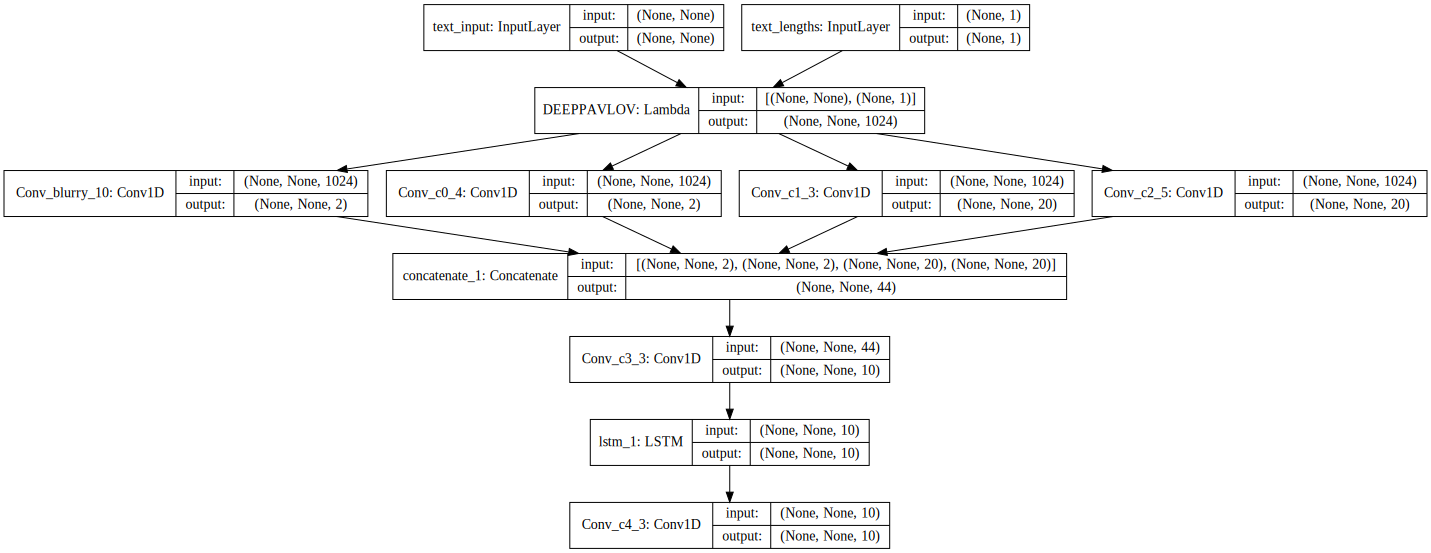

In [22]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

Train on 112 samples, validate on 38 samples
Epoch 1/40
112/112 [==============================] - 20s 175ms/step - loss: 4825.0918 - acc: 0.0035 - val_loss: 4395.1418 - val_acc: 0.0034
Epoch 2/40
112/112 [==============================] - 18s 158ms/step - loss: 4588.8695 - acc: 0.0544 - val_loss: 3949.5745 - val_acc: 0.3472
Epoch 3/40
112/112 [==============================] - 17s 154ms/step - loss: 4042.5085 - acc: 0.1181 - val_loss: 3520.7678 - val_acc: 0.0052
Epoch 4/40
112/112 [==============================] - 17s 152ms/step - loss: 3675.8447 - acc: 0.0034 - val_loss: 3371.0997 - val_acc: 0.0056
Epoch 5/40
112/112 [==============================] - 17s 152ms/step - loss: 3560.3232 - acc: 0.0043 - val_loss: 3368.5804 - val_acc: 0.0034
Epoch 6/40
112/112 [==============================] - 17s 154ms/step - loss: 3479.8703 - acc: 0.0087 - val_loss: 3297.2016 - val_acc: 0.0143
Epoch 7/40
112/112 [==============================] - 17s 154ms/step - loss: 3367.9936 - acc: 0.0128 - val_lo

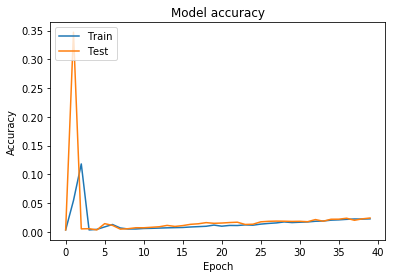

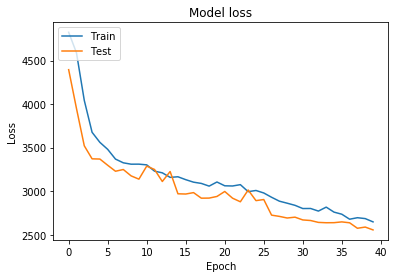

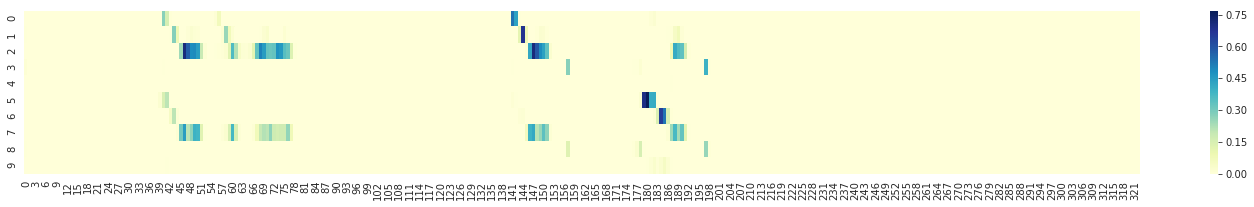

In [23]:

with graph.as_default():  
 
  with tf.Session() as sess:
   
    K.set_session(sess) 
    
    for i in range(1):
      history = model.fit([_TEXTS[5:], _LENS[5:] ], np_LABELS[5:], validation_split=0.25, epochs=EPOCHS, batch_size=30)
      plot_training_history(history)
      pred = model.predict([ [TEST_TOKENS, TEST_TOKENS], [len(TEST_TOKENS), len(TEST_TOKENS)] ])
      
      plot_matrix(pred[0])

      



## 2: LSTM Simplest Model

In [0]:
def build_lstm_simple_model(features): 

  # inputs:--------------------------------------------------------------------
  text_input = Input(shape=[None,], dtype='string', name="text_input")
  text_lengths = Input(batch_shape=[None, 1], dtype='int32', name='text_lengths')
  # ------------------------------------------------------------------- /inputs
   
  _out = Lambda(get_embedings, elmo_output_shape, name="deeppavlov".upper())( [text_input, text_lengths]  )
  _out = get_conv_pool(_out, 'c3', n=3, feature_maps=features, activation='sigmoid') 
  _out = LSTM(features, return_sequences=True)(_out)   
  _out = get_conv_pool(_out, 'c4', n=3, feature_maps=features, activation='sigmoid')
  
  model = Model(inputs=[text_input, text_lengths], outputs=_out)

  adam = Adam(lr=0.05, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(loss=custom_categorical_crossentropy, optimizer=adam, metrics=['accuracy'])
  model.summary()
  
  return model

In [25]:
graph = tf.Graph()
with graph.as_default():  
  elmo = hub.Module(module_url, trainable=False)
  model = build_lstm_simple_model( np_LABELS.shape[-1] )


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f63109b4358>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
text_lengths (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
DEEPPAVLOV (Lambda)             (None, None, 1024)   0           text_input[0][0]                 
                                                                 text_lengths[0][0]               
__________________________________________________________________________________________________
Conv_c3_3 (Conv1D)              (None, None, 10)     30730       DEEPPAVLOV[0][0]                 
__________

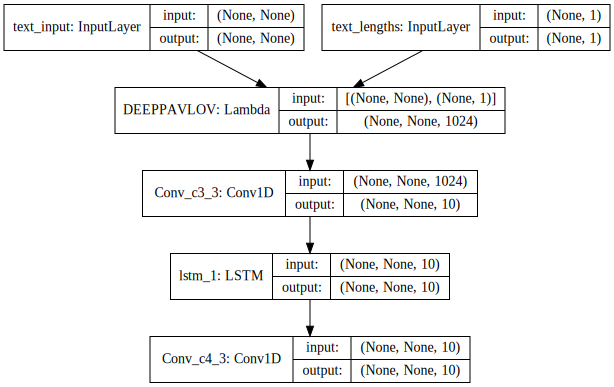

In [26]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

Train on 112 samples, validate on 38 samples
Epoch 1/40
112/112 [==============================] - 19s 173ms/step - loss: 4788.7820 - acc: 0.2293 - val_loss: 4195.1021 - val_acc: 0.9485
Epoch 2/40
112/112 [==============================] - 17s 153ms/step - loss: 4213.9560 - acc: 0.9179 - val_loss: 3534.5016 - val_acc: 0.9731
Epoch 3/40
112/112 [==============================] - 18s 157ms/step - loss: 3620.4472 - acc: 0.9704 - val_loss: 3277.8799 - val_acc: 0.2594
Epoch 4/40
112/112 [==============================] - 17s 156ms/step - loss: 3463.1630 - acc: 0.1066 - val_loss: 3162.0042 - val_acc: 0.0567
Epoch 5/40
112/112 [==============================] - 17s 151ms/step - loss: 3273.8957 - acc: 0.0440 - val_loss: 3074.2939 - val_acc: 0.0325
Epoch 6/40
112/112 [==============================] - 17s 151ms/step - loss: 3204.5434 - acc: 0.0454 - val_loss: 3003.0637 - val_acc: 0.0996
Epoch 7/40
112/112 [==============================] - 17s 152ms/step - loss: 3154.8389 - acc: 0.0751 - val_lo

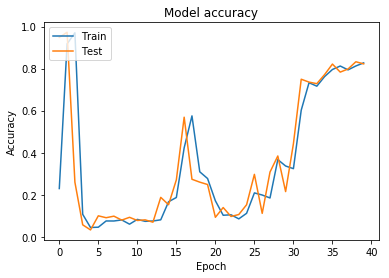

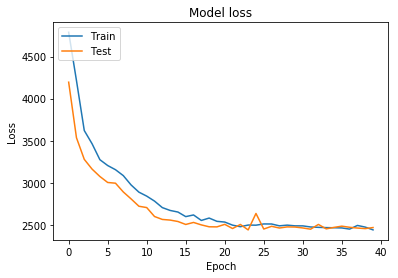

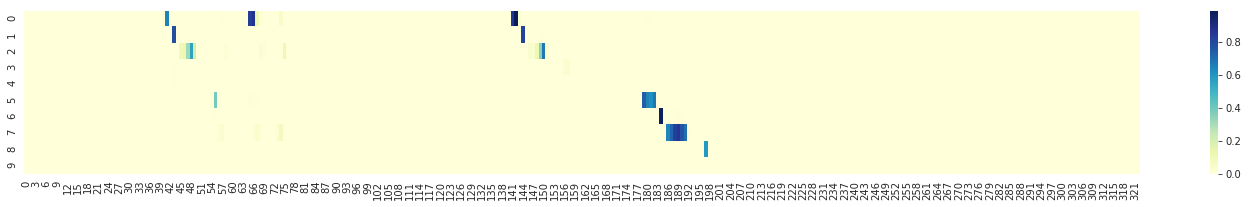

In [27]:
with graph.as_default():  
 
  with tf.Session() as sess:
   
    K.set_session(sess) 
    
    for i in range(1):
      history = model.fit([_TEXTS[5:], _LENS[5:] ], np_LABELS[5:], validation_split=0.25, epochs=EPOCHS, batch_size=30)
      plot_training_history(history)
      pred = model.predict([ [TEST_TOKENS, TEST_TOKENS], [len(TEST_TOKENS), len(TEST_TOKENS)] ])
      
      plot_matrix(pred[0])
#       color_matrix(pred[0], TEST_TOKENS)

## 3: 2-LSTM (one goes backwards ) Model

In [0]:
def build_lstm_2_model(features): 

  # inputs:--------------------------------------------------------------------
  text_input = Input(shape=[None,], dtype='string', name="text_input")
  text_lengths = Input(batch_shape=[None, 1], dtype='int32', name='text_lengths')
  # ------------------------------------------------------------------- /inputs
   
  _out = Lambda(get_embedings, elmo_output_shape, name="deeppavlov".upper())( [text_input, text_lengths]  )
  _out = get_conv_pool(_out, 'c3', n=3, feature_maps=features, activation='sigmoid') 

  l1 = LSTM(features, return_sequences=True)(_out)   
  l2 = LSTM(features, return_sequences=True, go_backwards=True)(_out)   
  
  _out = Concatenate()([l1, l2]) 
  
  _out = get_conv_pool(_out, 'c4', n=3, feature_maps=features, activation='sigmoid')
  
  model = Model(inputs=[text_input, text_lengths], outputs=_out)

  adam = Adam(lr=0.05, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(loss=custom_categorical_crossentropy, optimizer=adam, metrics=['accuracy'])
  model.summary()
  
  return model

In [29]:
graph = tf.Graph()
with graph.as_default():  
  elmo = hub.Module(module_url, trainable=False)
  model = build_lstm_2_model( np_LABELS.shape[-1] )


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
text_lengths (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
DEEPPAVLOV (Lambda)             (None, None, 1024)   0           text_input[0][0]                 
                                                                 text_lengths[0][0]               
__________________________________________________________________________________________________
Conv_c3_3 (Conv1D)              (None, None, 10)     30730       DEEPPAVLOV[0][0]                 
__________

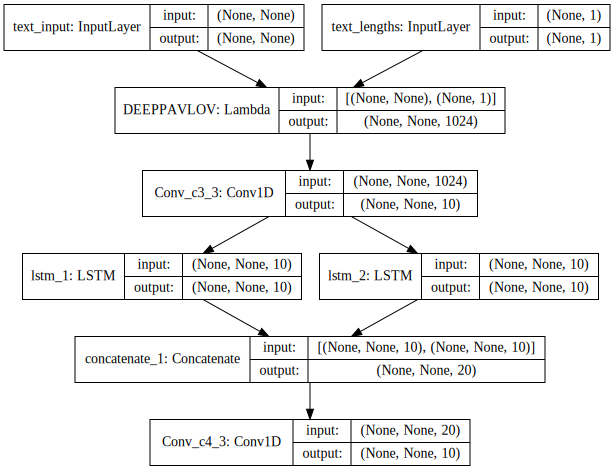

In [30]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

Train on 112 samples, validate on 38 samples
Epoch 1/40
112/112 [==============================] - 23s 206ms/step - loss: 4795.6246 - acc: 0.7145 - val_loss: 4206.6098 - val_acc: 0.8795
Epoch 2/40
112/112 [==============================] - 20s 180ms/step - loss: 4256.0577 - acc: 0.3869 - val_loss: 3692.1205 - val_acc: 0.0953
Epoch 3/40
112/112 [==============================] - 20s 180ms/step - loss: 3777.9953 - acc: 0.1103 - val_loss: 3354.4539 - val_acc: 0.1010
Epoch 4/40
112/112 [==============================] - 21s 185ms/step - loss: 3493.7944 - acc: 0.1132 - val_loss: 3107.8997 - val_acc: 0.0242
Epoch 5/40
112/112 [==============================] - 20s 179ms/step - loss: 3254.9546 - acc: 0.0451 - val_loss: 3034.7355 - val_acc: 0.0745
Epoch 6/40
112/112 [==============================] - 21s 185ms/step - loss: 3143.9707 - acc: 0.1077 - val_loss: 2946.2282 - val_acc: 0.0937
Epoch 7/40
112/112 [==============================] - 20s 180ms/step - loss: 3092.6541 - acc: 0.1050 - val_lo

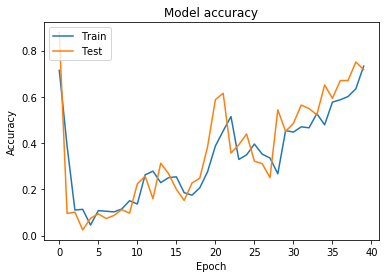

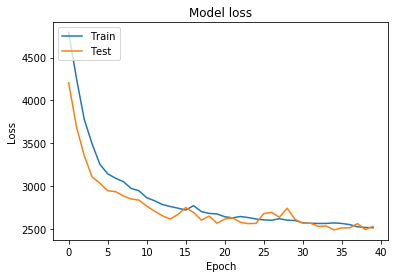

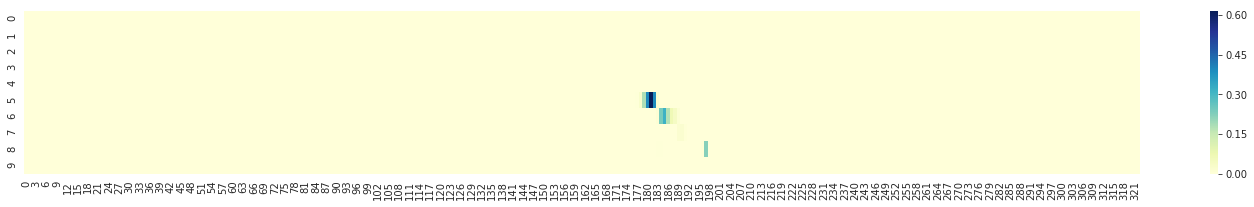

In [31]:
with graph.as_default():  
 
  with tf.Session() as sess:
   
    K.set_session(sess) 
    
    for i in range(1):
      history = model.fit([_TEXTS[5:], _LENS[5:] ], np_LABELS[5:], validation_split=0.25, epochs=EPOCHS, batch_size=30)
      plot_training_history(history)
      pred = model.predict([ [TEST_TOKENS, TEST_TOKENS], [len(TEST_TOKENS), len(TEST_TOKENS)] ])
      
      plot_matrix(pred[0])
#       color_matrix(pred[0], TEST_TOKENS)